# Introduction

## About

Image classifier that recognizes different Brazilian Jiu Jitsu grappling positions and predicts future outcomes! Uses a sequential neural network trained on a dataset of mounts/guards/submissions/areas of control to label the most resembled situation and a decision tree map to return the k-closest neighbours

## Editorial

```
V1: Multi-class classifier without decision tree algorithm, trained on: armbar, arm triangle, double-leg, guillotine, koshi guruma, leg triangle, rnc

    Notes:
    - Best result: 96% training acc, 65% validation acc
    - Need to: optimize regularization techniques to work effectively (not underfit)
    - May need more data and a more complex model
```

## Flow Chart

This flow chart/decision tree maps different submissions/escapes/passes and takedowns according to the starting position. The highlighted colours give a rough idea of the quality of respective data per query on ~100 google images.

```
Dark grey: very poor,
Grey: poor,
Light grey: average,
Green: good,
Blue: very good
```

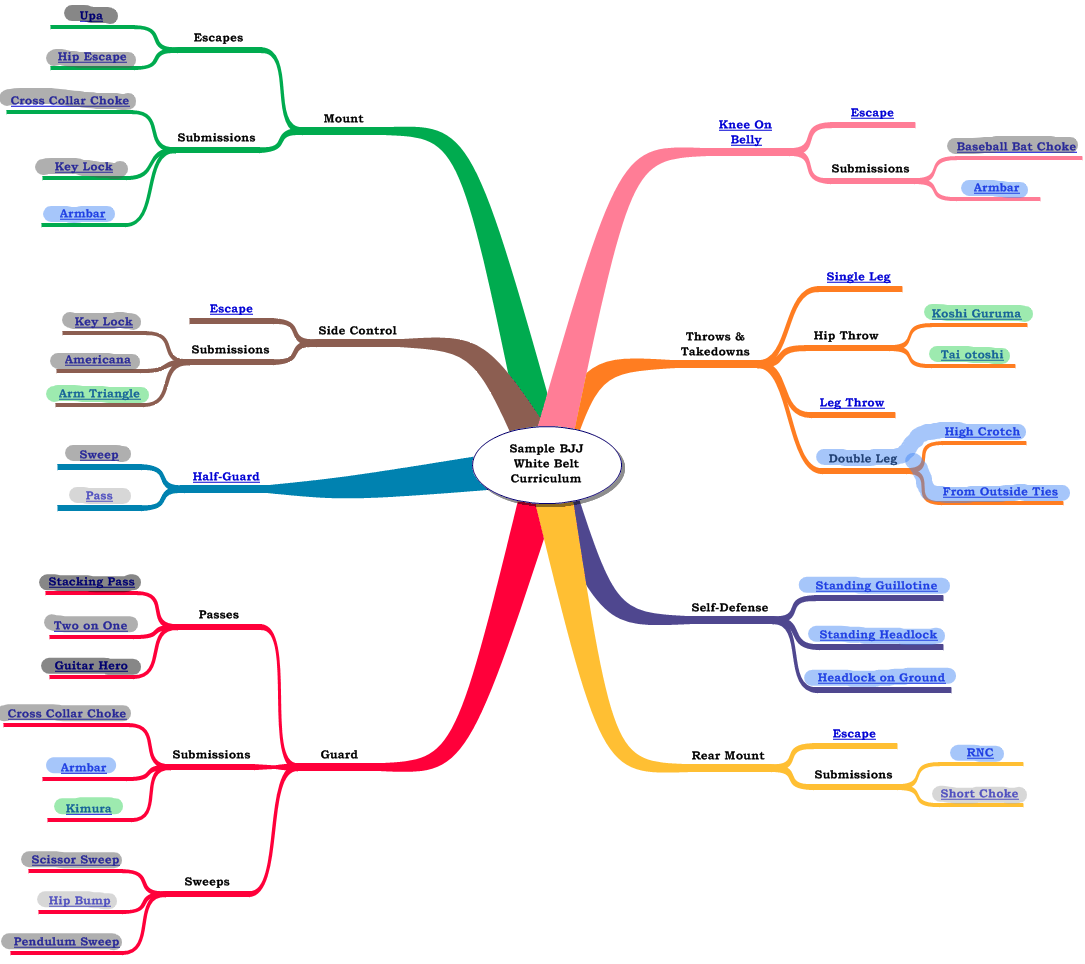

## 1. Dependencies

In [ ]:
!pip install tensorflow opencv-python matplotlib
!pip install keras

In [ ]:
!pip list

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import to_categorical
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import imghdr
import numpy as np

## 2. Configure Setup

In [3]:
# # *** This only works natively with NVIDIA gpus
# Avoid Out of Memory errors by enabling VRAM consumption growth
# gpu = tf.config.experimental.list_physical_devices('gpu')
# tf.config.experimental.set_memory_growth(gpu, True)

## 3. Import Data

#### Remove unwanted images

In [4]:
data_dir = "../JiuJitsuAI/Data"
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

#### Display a mock batch of images

In [6]:
images = tf.keras.utils.image_dataset_from_directory('../JiuJitsuAI/Data')

Found 1444 files belonging to 7 classes.


In [65]:
image_iterator = images.as_numpy_iterator()

In [72]:
batch = image_iterator.next()

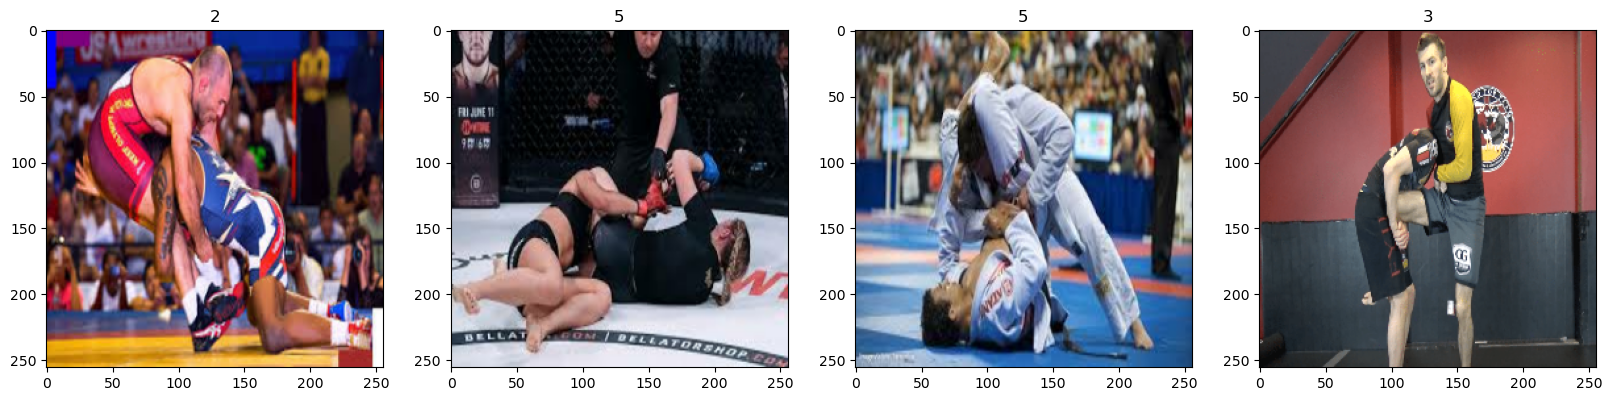

In [73]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int), cmap='gray', vmin=0, vmax=1)
  ax[idx].title.set_text(batch[1][idx])

## 4. Preprocess Data

In [76]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset='training'
)
data = data.map(lambda x, y: (x / 255.0, y))

Found 1444 files belonging to 7 classes.
Using 1011 files for training.


In [77]:
val = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
val = val.map(lambda x, y: (x / 255.0, y))

Found 1444 files belonging to 7 classes.
Using 288 files for validation.


In [78]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
test = test.map(lambda x, y: (x / 255.0, y))

Found 1444 files belonging to 7 classes.
Using 144 files for validation.


## 5. Build Model

In [79]:
model = Sequential()

In [80]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [81]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 6. Train Model

In [83]:
logdir = '../JiuJitsuAI/Logs'

In [84]:
#Log out model training as it trains
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [85]:
#Data, how long you will train for, after all training batches are run validation data is used, additional callbacks
history = model.fit(
    data,
    epochs=10,
    validation_data=val,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
32/32 [==============================] - 33s 940ms/step - loss: 0.4275 - accuracy: 0.2166 - val_loss: 0.3902 - val_accuracy: 0.2847
Epoch 2/10
32/32 [==============================] - 31s 937ms/step - loss: 0.3604 - accuracy: 0.3867 - val_loss: 0.3632 - val_accuracy: 0.3438
Epoch 3/10
32/32 [==============================] - 30s 926ms/step - loss: 0.2765 - accuracy: 0.6241 - val_loss: 0.3514 - val_accuracy: 0.4236
Epoch 4/10
32/32 [==============================] - 30s 922ms/step - loss: 0.1646 - accuracy: 0.8061 - val_loss: 0.3468 - val_accuracy: 0.5174
Epoch 5/10
32/32 [==============================] - 31s 948ms/step - loss: 0.0986 - accuracy: 0.8952 - val_loss: 0.4180 - val_accuracy: 0.5312
Epoch 6/10
32/32 [==============================] - 31s 938ms/step - loss: 0.0571 - accuracy: 0.9594 - val_loss: 0.4882 - val_accuracy: 0.5312
Epoch 7/10
32/32 [==============================] - 31s 939ms/step - loss: 0.0447 - accuracy: 0.9654 - val_loss: 0.4689 - val_accuracy: 0.5347